<a href="https://colab.research.google.com/github/david-adewoyin/HackerNews/blob/main/exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing Hacker News data

To run this analysis, A web scrapper was built that crawled the official [Hacker News API](https://github.com/HackerNews/API), and obtained a list of posts during the months of July - Oct 2022. Posts including comments,stories and jobs were scrapped and user information and karma points were also included in the dataset.

In [ ]:
# donwloading packages for later uses
!pip install spacy-transformers
! python -m spacy download en_core_web_trf 

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns

import spacy
import spacy_transformers
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

Loading the dataset

In [3]:
# reading in the dataset
hn_posts = pd.read_csv("https://media.githubusercontent.com/media/david-adewoyin/HackerNews/main/data/hn_posts.csv",
          names=['id','type','parent','text','kids','comment_counts','score','title','posted_by','created_at']
           )
hn_users = pd.read_csv("https://media.githubusercontent.com/media/david-adewoyin/HackerNews/main/data/hn_users.csv",
                       names=['name','karma','created_at'])

In [4]:
# display a sample of the posts table
hn_posts.sample(5)

,id,type,parent,text,kids,comment_counts,score,title,posted_by,created_at
949446,32448574,comment,32448533.0,Whoosh,NaN,NaN,NaN,NaN,tomxor,1660387693
305845,33092148,story,NaN,NaN,NaN,NaN,1.0,NaN,viralnewly,1664952893
161932,33236061,comment,33235529.0,&gt; there are numerous other search engines a...,NaN,NaN,NaN,NaN,jjslocum3,1666024723
276290,33121773,comment,33120634.0,"<a href=""https:&#x2F;&#x2F;archive.ph&#x2F;Tig...",NaN,NaN,NaN,NaN,beardyw,1665152716
62999,33335042,story,NaN,NaN,NaN,0.0,2.0,Canada commits CAD $970M to build small modula...,beefman,1666726091


In [5]:
print(f"Shape of posts {hn_posts.shape}")
print(f"Shape of users table {hn_users.shape}")

Shape of posts (1127716, 10)
Shape of users table (77882, 3)


In [6]:
# checking the type of posts we have
hn_posts['type'].value_counts()

comment    1030581
story        96753
job            231
pollopt        126
poll            25
Name: type, dtype: int64

We have more than a million comments and 90k+ stories in the dataset.

### Cleaning the dataset
Now we clean our dataset and remove `null` values in columns where we are dont expect them, we also convert `timestamp` into `date time` object for easy analysis.

In [7]:
# checking number of missing values in each column
hn_posts.isna().sum()

id                      0
type                    0
parent              97135
text               140090
kids               620919
comment_counts    1052406
score             1033395
title             1052176
posted_by           31101
created_at              0
dtype: int64

In [8]:
## dropping all posts where posted_by is null, we expect posted_by to not contain null values
hn_posts = hn_posts[hn_posts['posted_by'].notnull()];

In [ ]:
#converting the created_at column into datetime 
dict_map = {0: 'Sun', 1: 'Mon',2:"Tue",3:'Wed',4:'Thur',5:'Fri',6:'Sat'}

hn_posts['created_at'] = pd.to_datetime(hn_posts['created_at'],unit='s') 
hn_posts['date'] = hn_posts['created_at'].dt.date
hn_posts['day_of_week'] = hn_posts['created_at'].dt.day_of_week.map(dict_map)
hn_posts['hour'] = hn_posts['created_at'].dt.hour

In [10]:
# extract story type from the table
stories = hn_posts.query("type == 'story'")

## Exploratory Analysis
In this section, we perform exploratory analysis and try to answer questions such as:
- What time and day of the week receives the highest engagement.
- What are the top stories during the period.
- Which posts receives the highest form of engagements.
- What do people talk about, etc.

Text(0.5, 1.0, 'Average score by dy of week')

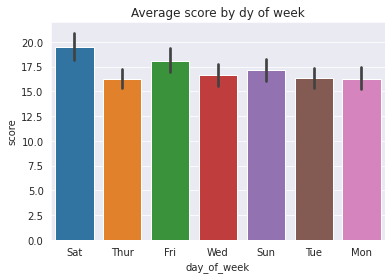

In [11]:
# day of week were posts have the highest scores
sns.barplot(data=stories,x='day_of_week',y='score')
plt.title("Average score by dy of week")

Saturday seems the day were posts seems to score the highest

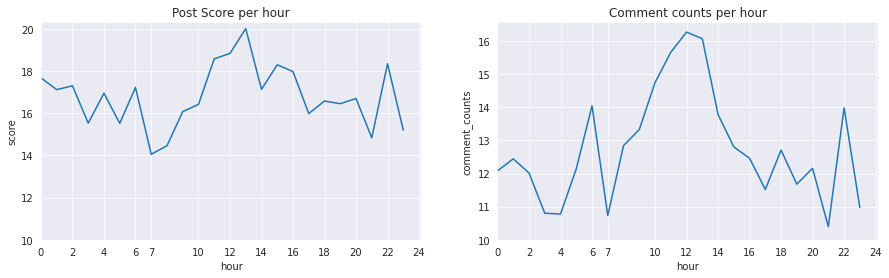

In [12]:
fig,axes = plt.subplots(1,2,sharex=True)
fig.set_figwidth(15)
sns.lineplot(data=stories,x='hour',y='score',ci=None,ax=axes[0])
sns.lineplot(data=stories,x='hour',y='comment_counts',ci=None,ax=axes[1])
for ax in axes:
    ax.set_ylim(ymin=10)
    ax.set_xlim(xmin=0)
axes[0].set_title('Post Score per hour')
axes[1].set_title("Comment counts per hour")
plt.xticks([0,2,4,6,7,10,12,14,16,18,20,22,24]);

The best time to post a story seems to be between *12pm - 1pm* GMT +1, this period as might be expected seems also has more interaction by comment counts. 

## Top Stories on Hackernews
Now let check for the top stories posted on Hackernews during the months the data was collected. We define a top story by the score it has.

In [13]:
# filtering the data to posts were title were included
stories_titled = stories[stories['title'].notnull()]
top_stories = stories_titled.sort_values('score',ascending=False)

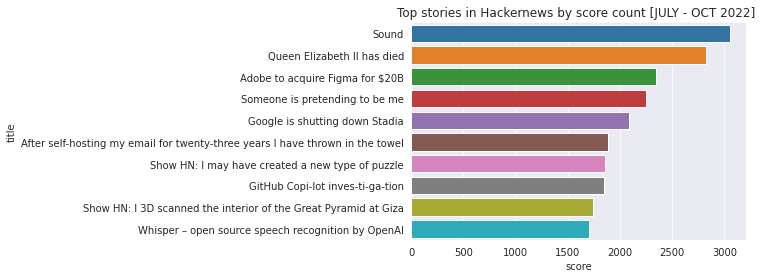

In [14]:
sns.barplot(data=top_stories.iloc[:10],y='title',x='score')
plt.title("Top stories in Hackernews by score count [JULY - OCT 2022] ");

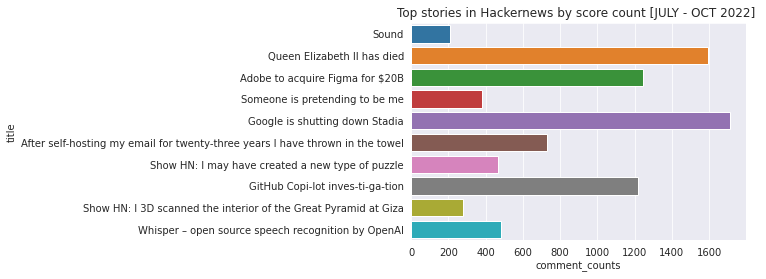

In [15]:
sns.barplot(data=top_stories.iloc[:10],y='title',x='comment_counts')
plt.title("Top stories in Hackernews by score count [JULY - OCT 2022] ");

An important fact can be seen from the data, stories having a high score does not necessarily have a higher form of engagement in terms of comment count, but as we will later see stories with a high score does usually have more engagement.

Just as expected, Google shutting down stadia and the death of queen Elizabeth have higher engagement.

## Stories with the highest comment counts.
Now, we turn our attention to see the stories on hackernews that had the highest comment.

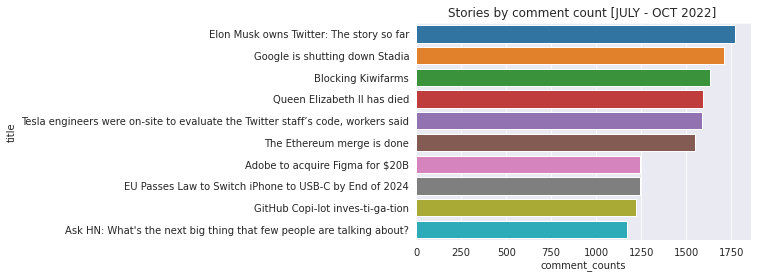

In [16]:
stories_by_comment = stories_titled.sort_values('comment_counts',ascending=False)
sns.barplot(data=stories_by_comment.iloc[:10],y='title',x='comment_counts')
plt.title("Stories by comment count [JULY - OCT 2022] ");

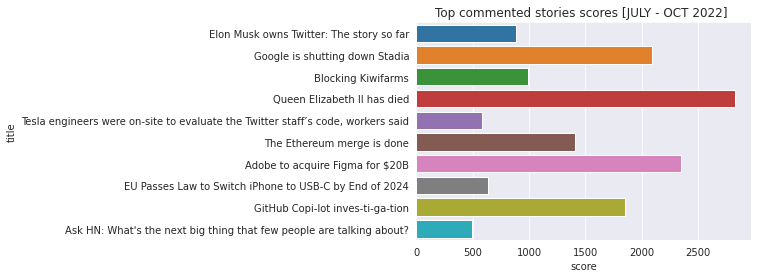

In [17]:
sns.barplot(data=stories_by_comment.iloc[:10],y='title',x='score')
plt.title("Top commented stories scores [JULY - OCT 2022] ");

`4 out of 10 stories` in the top 10 stories by score are also in the list of top stories by comment counts.

## Entity Recognition
Finally, we try to answer the question who and what do people talk about on hackernews during the period by analysing the titles of the best posts and extracting the entities found in them

In [18]:
## initializing the entity recognition model
nlp = spacy.load('en_core_web_trf')

In [19]:
## find the various entities in a hackernews post
def find_entity(title):
  entity_names = []
  parsed_title = nlp(title)
  for  entity in  parsed_title.ents:
    entity_names.append(entity.text)
    return ' '.join(entity_names)

In [20]:
# get the top 1000 stories by score count and run it through the entity recognition model
top_stories_1000 = stories_titled.sort_values('score',ascending=False).iloc[:1000]
top_stories_1000['entity'] = top_stories_1000["title"].apply(find_entity)

In [21]:
top_stories_1000[['title','entity']].head(20)

,title,entity
148797,Sound,None
629106,Queen Elizabeth II has died,Elizabeth II
547825,Adobe to acquire Figma for $20B,Adobe
401070,Someone is pretending to be me,None
375273,Google is shutting down Stadia,Google
682640,After self-hosting my email for twenty-three y...,twenty-three years
513621,Show HN: I may have created a new type of puzzle,None
157609,GitHub Copi­lot inves­ti­ga­tion,GitHub
40902,Show HN: I 3D scanned the interior of the Grea...,Giza
470602,Whisper – open source speech recognition by Op...,OpenAI


In [22]:
en_series = top_stories_1000[top_stories_1000['entity'].notnull()]['entity']

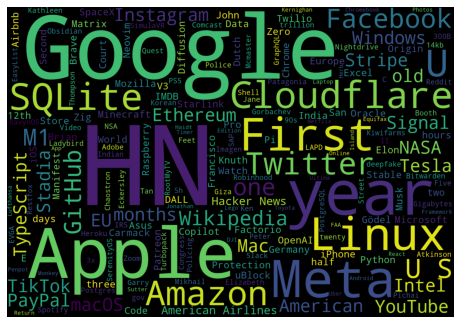

In [23]:
# displaying the top entities in a word cloud
cloud = WordCloud(width=1440,height=1000,max_words=200).generate(' '.join(en_series))
plt.figure(figsize=(8, 6))
plt.imshow(cloud)
plt.axis('off');
plt.show()

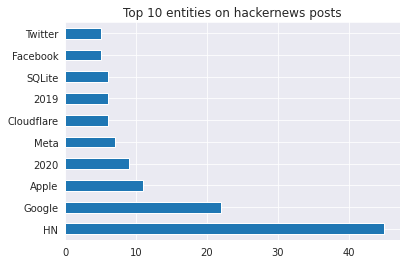

In [24]:
# plotting the top entites
en_series.value_counts()[:10].plot(kind='barh')
plt.title("Top 10 entities on hackernews posts");

## Conclusion
That comes to end of our analysis, there is more that could be have done, such as analysing the different types of posts and also examining the comments.